# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("WineKMC.xlsx", sheet_name=0)

/Users/cortega/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


### 1b. Explore the data

In [3]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


In [4]:
df_offers.shape

(32, 7)

We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [5]:
#read transaction worksheeet
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)

#rename columns to tidier format to be used when merging
df_transactions.columns = ["customer_name", "offer_id"]

#add a column called 'n' and fill with 1 for each transaction
df_transactions['n'] = 1
df_transactions.head()


/Users/cortega/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


In [6]:
df_transactions.shape

(324, 3)

## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [7]:
#your turn
merge = df_offers.merge(df_transactions, on='offer_id', how='inner')
merge.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n
0,1,January,Malbec,72,56,France,False,Thomas,1
1,1,January,Malbec,72,56,France,False,Jackson,1
2,1,January,Malbec,72,56,France,False,Mitchell,1
3,1,January,Malbec,72,56,France,False,Peterson,1
4,1,January,Malbec,72,56,France,False,Wood,1


In [8]:
pivot = pd.pivot_table(merge, index='customer_name', columns='offer_id', values='n', fill_value=0).reset_index().rename_axis(None, axis=1)
pivot.head()

,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,Allen,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,Anderson,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,Bailey,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Baker,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [9]:
#spot check to see if the pivot table is correct:
print(merge[merge['customer_name'] == 'Adams'])
print(merge[merge['customer_name'] == 'Allen'])
print(merge[merge['customer_name'] == 'Anderson'])
print(merge[merge['customer_name'] == 'Bailey'])
print(merge[merge['customer_name'] == 'Baker'])

#based on what's visible in pivot.head, the table has worked to give binary values indicated a customer's response to each campaign

     offer_id  campaign      varietal  min_qty  discount  origin  past_peak  \
166        18      July     Espumante        6        50  Oregon      False   
270        29  November  Pinot Grigio        6        87  France      False   
288        30  December        Malbec        6        54  France      False   

    customer_name  n  
166         Adams  1  
270         Adams  1  
288         Adams  1  
     offer_id campaign    varietal  min_qty  discount       origin  past_peak  \
98          9    April  Chardonnay      144        57        Chile      False   
252        27  October   Champagne       72        88  New Zealand      False   

    customer_name  n  
98          Allen  1  
252         Allen  1  
     offer_id   campaign    varietal  min_qty  discount     origin  past_peak  \
218        24  September  Pinot Noir        6        34      Italy      False   
236        26    October  Pinot Noir      144        83  Australia      False   

    customer_name  n  
218      An

In [10]:
#check to make sure we un-nested all column names in the pivot
pivot.columns

Index(['customer_name',               1,               2,               3,
                     4,               5,               6,               7,
                     8,               9,              10,              11,
                    12,              13,              14,              15,
                    16,              17,              18,              19,
                    20,              21,              22,              23,
                    24,              25,              26,              27,
                    28,              29,              30,              31,
                    32],
      dtype='object')

In [11]:
#check for any other weird values
pivot.nunique()

#looks like each column only has 2 unique values: 0 and 1

customer_name    100
1                  2
2                  2
3                  2
4                  2
5                  2
6                  2
7                  2
8                  2
9                  2
10                 2
11                 2
12                 2
13                 2
14                 2
15                 2
16                 2
17                 2
18                 2
19                 2
20                 2
21                 2
22                 2
23                 2
24                 2
25                 2
26                 2
27                 2
28                 2
29                 2
30                 2
31                 2
32                 2
dtype: int64

In [12]:
#check shape--we have 100 customers and 32 marketing campaigns
pivot.shape

(100, 33)

## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

#What values of  𝑆𝑆  do you believe represent better clusterings? Why? 

We are looking for the value of k that gives the greatest reduction in SS before "leveling off" at an elbow. This shows that the given value of k is sufficiently explaining the variability between groups without overfitting to the variability within groups.

In [13]:
# Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums)
x_cols = pivot.drop(columns='customer_name').to_numpy()
x_cols

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 1]])

In [14]:
#Write code that applies the [`KMeans`] clustering method from scikit-learn to this matrix.
from sklearn.cluster import KMeans
#initialize model
kmeans1=KMeans(n_clusters=3, random_state=42)
#fit to data
kmeans1.fit_predict(x_cols)
#get SS value
kmeans1.inertia_

228.3105506822612

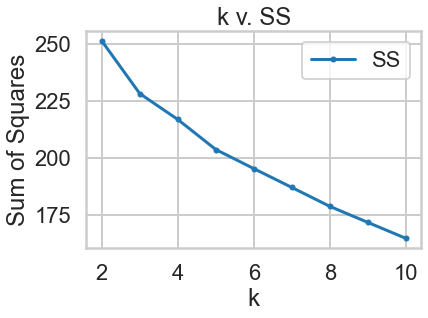

In [15]:
#Construct a plot showing  𝑆𝑆  for each  𝐾  and pick  𝐾  using this plot. 
#For simplicity, test  2≤𝐾≤10 .
ss_table = pd.DataFrame(columns=['k','SS'])
for k in range(2,11):
    kmeans=KMeans(n_clusters=k, random_state=42)
    kmeans.fit_predict(x_cols)
    SS = kmeans.inertia_
    ss_table.loc[len(ss_table.index)] = [k,SS] 


#plot the k v. SS curve
#plt.scatter(x='k', y='SS', data=ss_table, linestyle='solid')
ss_table.plot.line('k', 'SS', linestyle='solid', xlabel='k',ylabel='Sum of Squares',title='k v. SS',marker='o',markersize=5)
plt.show()

#sooooo...there's no clear 'elbow' here. There are slight elbows at k=3 and k=5.
#At k=3, the slope of the line decreases the most, so I'm going to go with k=3

[Text(0.5, 1.0, 'Cluster Counts for k=3')]

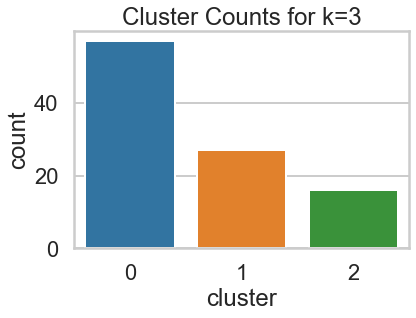

In [16]:
#Make a bar chart showing the number of points in each cluster for k-means under the best  𝐾 .
#add a cluster assignment column to the pivot df
pivot['cluster']=kmeans1.predict(x_cols)
pivot.head()

sns.countplot(x="cluster", data=pivot).set(title='Cluster Counts for k=3')

#What challenges did you experience using the Elbow method to pick  𝐾 ?

There was not an obvious elbow for this data set, which make choosing K seem kind of arbitrary. Additionally, when the random state of the KMeans clustering was varied, so too did the apparent elbow in the SS plot change.

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For n_clusters = 2 The average silhouette_score is : 0.09365573283492713
For n_clusters = 3 The average silhouette_score is : 0.11889942863638556
For n_clusters = 4 The average silhouette_score is : 0.12347053919571699
For n_clusters = 5 The average silhouette_score is : 0.14092516241984757
For n_clusters = 6 The average silhouette_score is : 0.1371798939109807
For n_clusters = 7 The average silhouette_score is : 0.1161092456616906
For n_clusters = 8 The average silhouette_score is : 0.11339573832632867
For n_clusters = 9 The average silhouette_score is : 0.12505960527779877
For n_clusters = 10 The average silhouette_score is : 0.11928332134753233


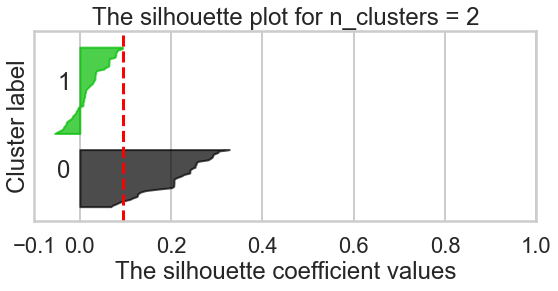

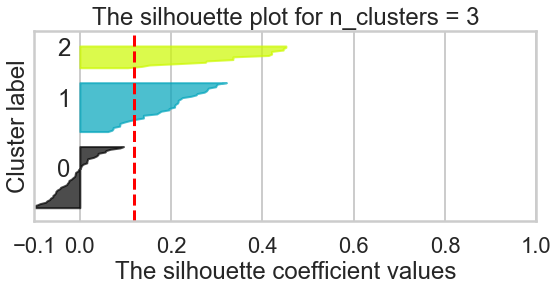

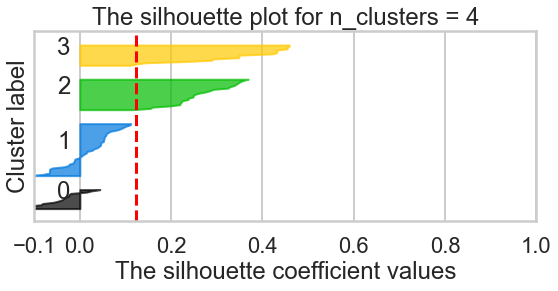

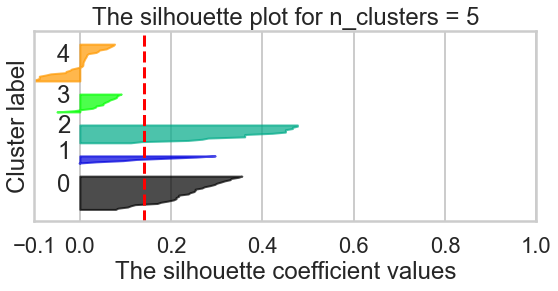

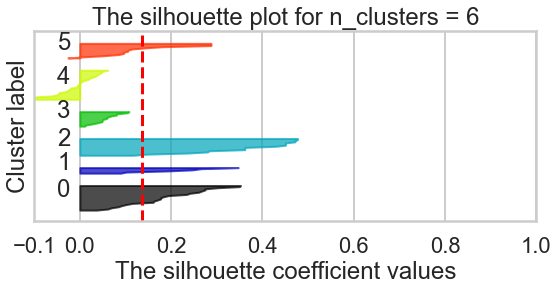

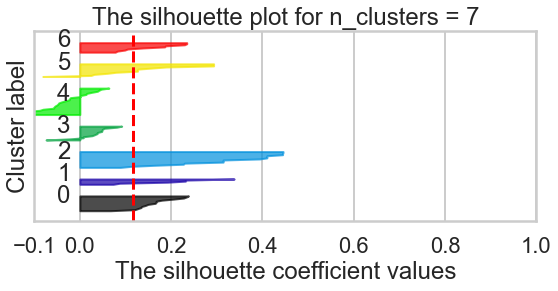

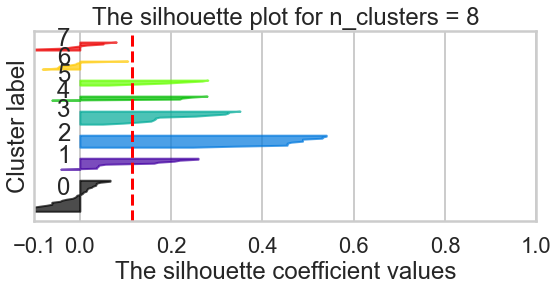

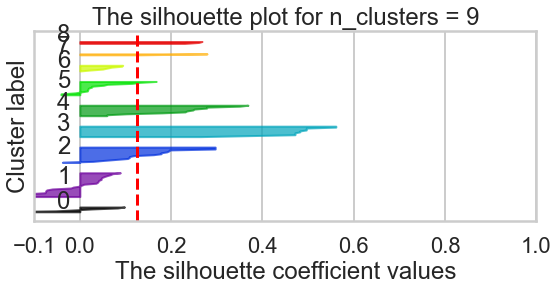

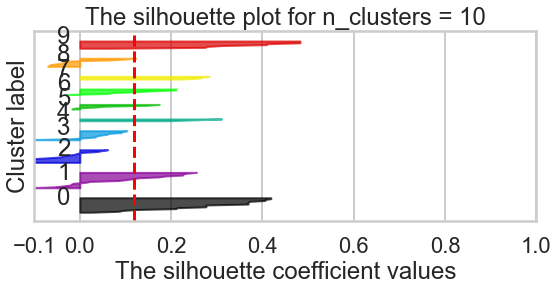

In [17]:
#Using the documentation for the `silhouette_score` function above,
#construct a series of silhouette plots like the ones in the article linked above.
#note: code is modified from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np

#initialize a df to hold scores
sil_table = pd.DataFrame(columns=['k','silhouette_score'])

for k in range(2,11):
    # Create a subplot with 1 row and 1 column
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(9, 3.5)
    
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_cols) + (k + 1) * 10])
    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusterer.fit_predict(x_cols)
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    print(
        "For n_clusters =",
        k,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    # add silhouette score to a table to plot later
    sil_table.loc[len(sil_table.index)] = [k,silhouette_avg] 
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for n_clusters = " + str(k))
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

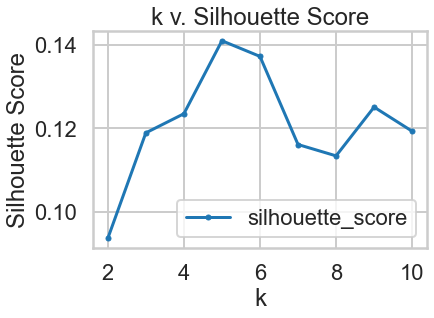

In [18]:
#Compute the average silhouette score for each  𝐾  and plot it. What  𝐾  does the plot suggest we should choose? 
#Does it differ from what we found using the Elbow method?
sil_table.plot.line('k', 'silhouette_score', linestyle='solid', xlabel='k',ylabel='Silhouette Score',title='k v. Silhouette Score',marker='o',markersize=5)
plt.show()

#The highest silhouette score occurs at k=5 rather than k=3, but all the clustering is pretty terrible!


#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

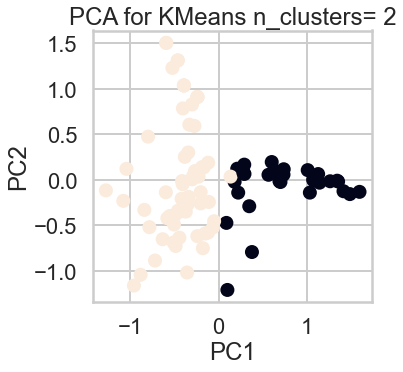

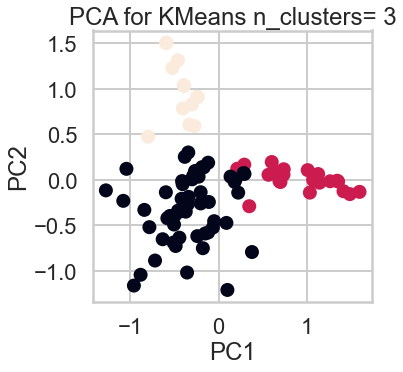

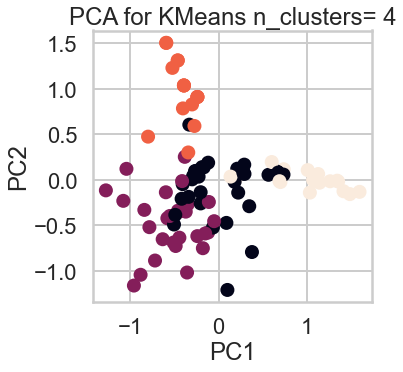

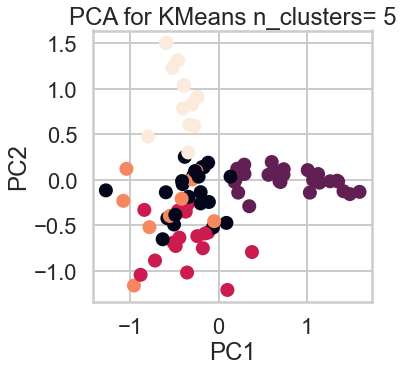

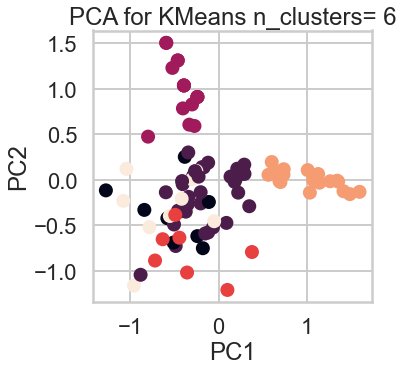

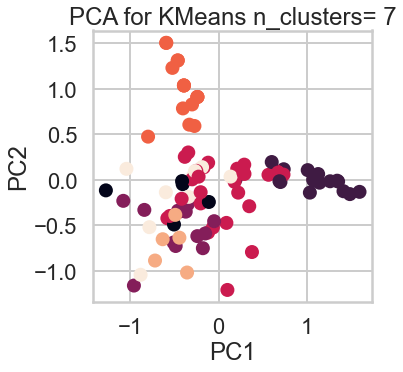

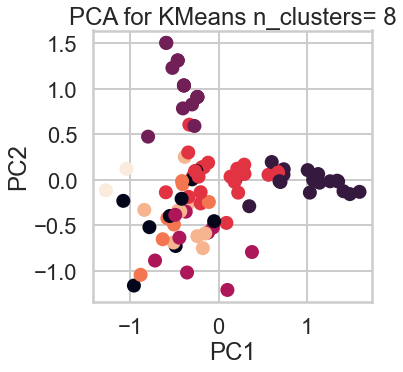

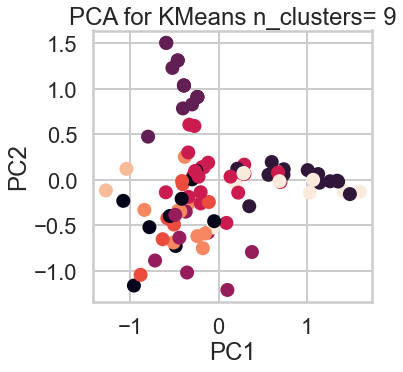

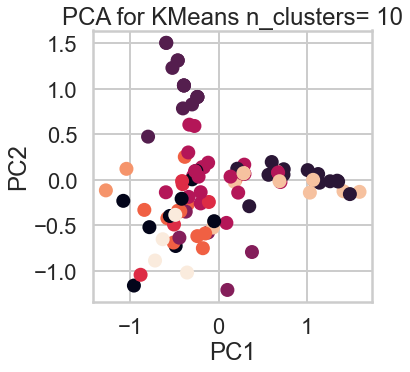

In [19]:
#use PCA to reduce dimensionality to 2 components
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pc1, pc2 = zip(*pca.fit_transform(x_cols))

for k in range(2,11):
    kmeans=KMeans(n_clusters=k, random_state=42)
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(5, 5)
    
    #create df with customer name, cluster id, pc1 and pc2
    pca_df = pd.DataFrame({'customer_name': pivot['customer_name'],
                      'cluster_id': kmeans.fit_predict(x_cols),
                      'x': pc1,
                      'y': pc2})

    #Plot a scatterplot of the `x` vs `y` columns
    #Color-code points differently based on cluster ID
    ax1 = plt.scatter('x', 'y', data=pca_df, c='cluster_id')
    ax1 = plt.xlabel('PC1')
    ax1 = plt.ylabel('PC2')
    ax1 = plt.title('PCA for KMeans n_clusters= ' + str(k))

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

Based on what you see, what seems to be the best value for  𝐾 ? Moreover, which method of choosing  𝐾  seems to have produced the optimal result visually?

Based on what I see from the PCA plots generated using clusters from the various KMeans clusterers, the plot that gives the greatest visual distinction between clusters is, by far, that generated from the n_clusters=3 KMeans clusterer. n_clusters=5 gives a lot of meaningless overlap between 3 groups on the PCA, indicating that those groupings are likely artificial

In [20]:
#Exercise: Now look at both the original raw data about the offers and transactions 
#and look at the fitted clusters. 
#Tell a story about the clusters in context of the original data. 
#For example, do the clusters correspond to wine variants or something else interesting?
kmeans=KMeans(n_clusters=3, random_state=42)
pivot['cluster']=kmeans.fit_predict(x_cols)
pivot.head()

df = pd.DataFrame.merge(merge, pivot, on='customer_name', how='inner')
df.head()


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n,1,...,24,25,26,27,28,29,30,31,32,cluster
0,1,January,Malbec,72,56,France,False,Thomas,1,1,...,0,0,1,0,0,0,0,0,0,0
1,4,February,Champagne,72,48,France,True,Thomas,1,1,...,0,0,1,0,0,0,0,0,0,0
2,9,April,Chardonnay,144,57,Chile,False,Thomas,1,1,...,0,0,1,0,0,0,0,0,0,0
3,11,May,Champagne,72,85,France,False,Thomas,1,1,...,0,0,1,0,0,0,0,0,0,0
4,14,June,Merlot,72,64,Chile,False,Thomas,1,1,...,0,0,1,0,0,0,0,0,0,0


In [21]:
pivot['cluster'].value_counts()

0    57
1    27
2    16
Name: cluster, dtype: int64

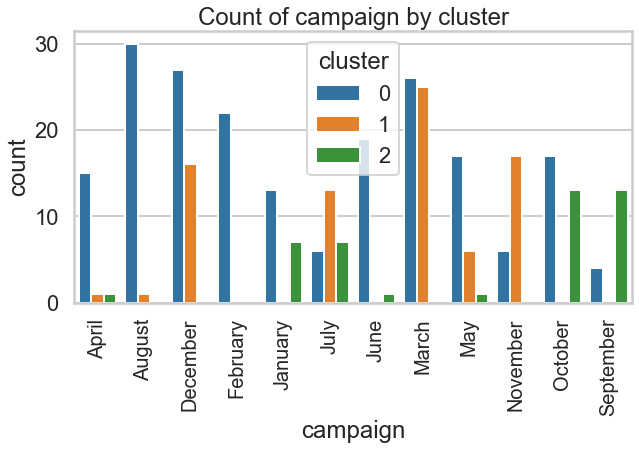

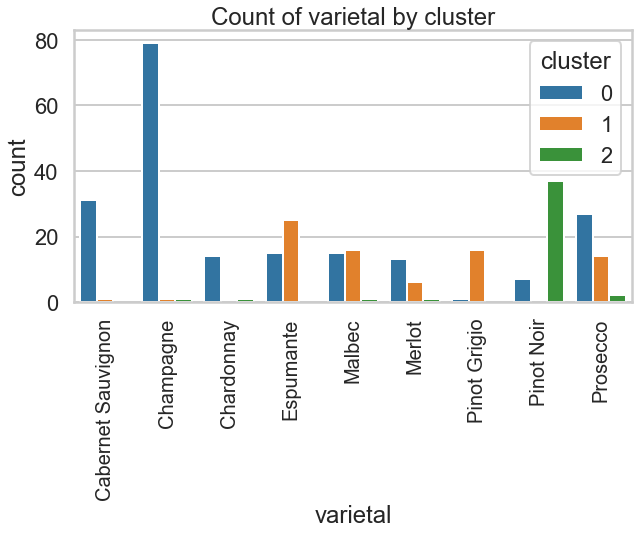

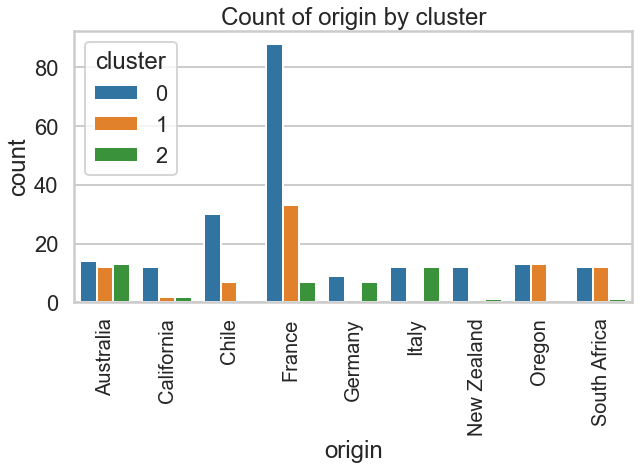

In [22]:
features=['campaign','varietal','origin']

for i in range(len(features)):
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(10, 5)
    ax1 = sns.countplot(x=features[i],data=df.sort_values(features[i]),hue='cluster')
    ax1 = plt.xticks(rotation=90, size=20)
    ax1 = plt.title('Count of '+ features[i] + ' by cluster')
    

#### Some conclusions:

**Cluster 0** accounted for the largest volume of customers (57%). The purchases these customers made took place throughout the year, often dominating the sales for each month and in the case of February, were the only sales. Notably, the cluster 0 customers were significantly less active in July, September, and November. Cluster 0 customers made purchases in every varietal category except for Pinot Grigio. Cabernet, Champagne and Chardonnay sales were *only* (with a couple individual exceptions) made to customers in Cluster 0. These customers bought wine from every region but showed a remarkable preference for wines from France, both within cluster and between clusters.

**Cluster 1** accounted for the 27% of customers. These customers were most active in March, May, July, November, and December. They made no purchases in Janurary, February, June, September or October. These customers were almost exclusively interested in Espumante, Malbec, Merlot, Pinot Grigio and Prosecco--no need to target them for marketing any other varietals. While they bought wines from Australia, Chile, France, Oregon and South America, the customers in Cluster 1 were uninterested in wines from California, Germany, Italy or New Zealand.

**Cluster 2** accounted for just 16% of customers. These customers were most active in January, July, September and October. They made no purchases in February, March, August, November or December. These customers were almost exclusively interested in Pinot Noir, and in fact dominate the Pinot Noir sales--no need to target them for marketing any other varietals. While they bought wines from Australia, Italy, Germany and France, the customers in Cluster 2 were mostly uninterested in wines from other regions.


Knowing the shopping characteristics of these various clusters of customers will shape our company's marketing strategies going forward. We are now empowered to target specific customers with specific marketing campaigns in order to best utilize our limited marketing budget, reduce unwanted spam marketing for uninterested customers, and design new marketing campaigns informed by customer behavior.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

([<matplotlib.axis.XTick at 0x7fa9415cd520>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

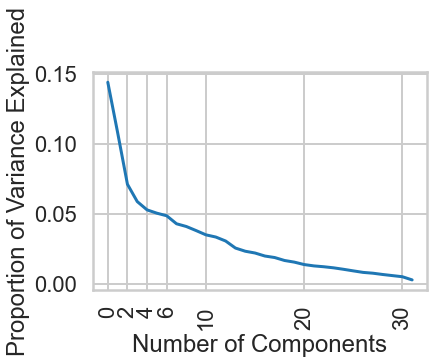

In [23]:
#your turn
# Initialize a new PCA model with a default number of components.

pca = PCA()
pca.fit(x_cols)

variance = pca.explained_variance_ratio_
plt.plot(range(len(variance)), variance)
plt.xlabel("Number of Components")
plt.ylabel("Proportion of Variance Explained")
plt.xticks([0,2,4,6,10,20,30], rotation=90)

#The plot of the explained variance shows a clear elbow at 2 components

## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


### Affinity Propagation

For damping = 0.5 The average silhouette_score is : 0.1287461263003752
For damping = 0.55 The average silhouette_score is : 0.1287461263003752
For damping = 0.6 The average silhouette_score is : 0.1287461263003752
For damping = 0.65 The average silhouette_score is : 0.1287461263003752
For damping = 0.7 The average silhouette_score is : 0.1287461263003752
For damping = 0.75 The average silhouette_score is : 0.1287461263003752
For damping = 0.8 The average silhouette_score is : 0.11230513430572384
For damping = 0.85 The average silhouette_score is : 0.11230513430572384
For damping = 0.9 The average silhouette_score is : 0.11230513430572384
For damping = 0.95 The average silhouette_score is : 0.11230513430572384


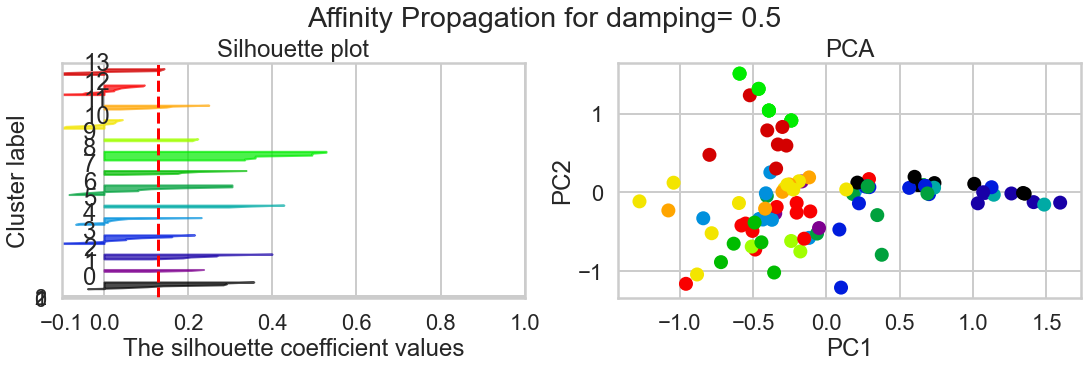

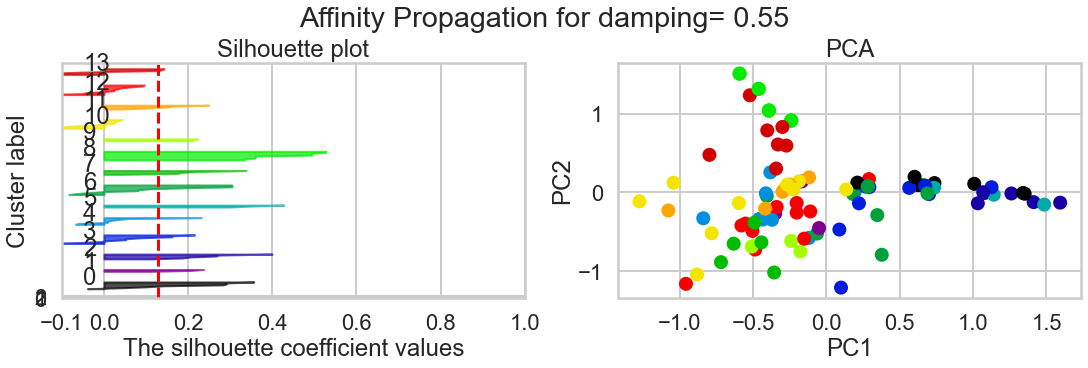

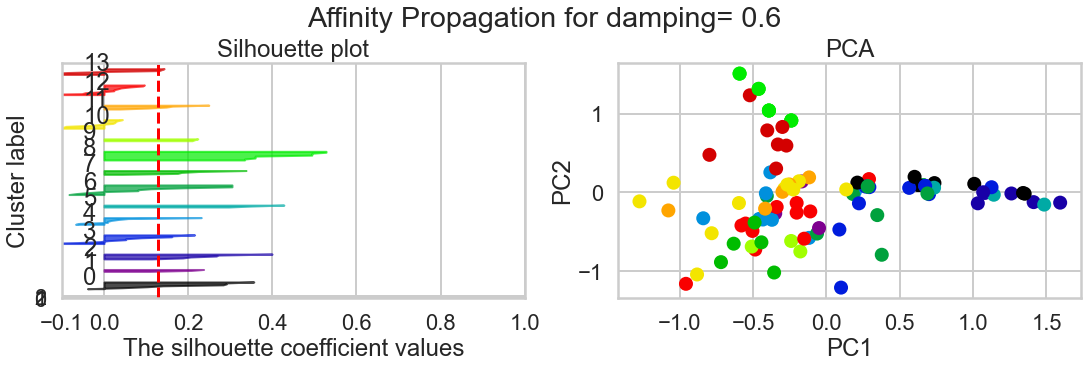

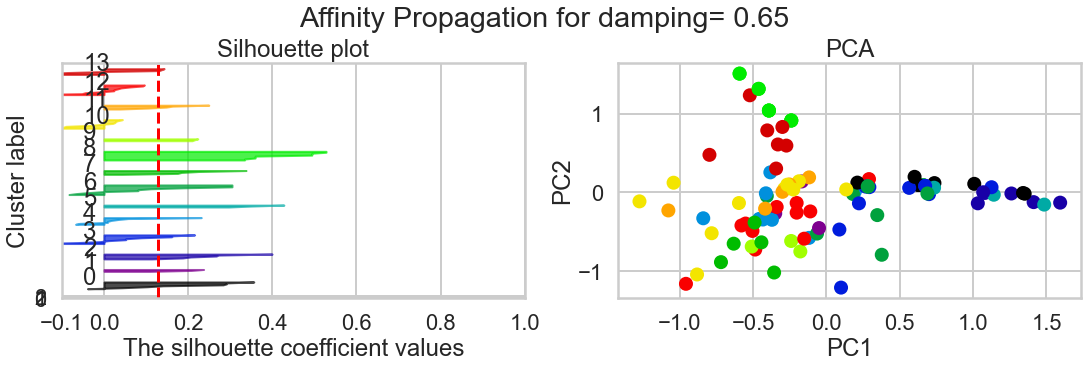

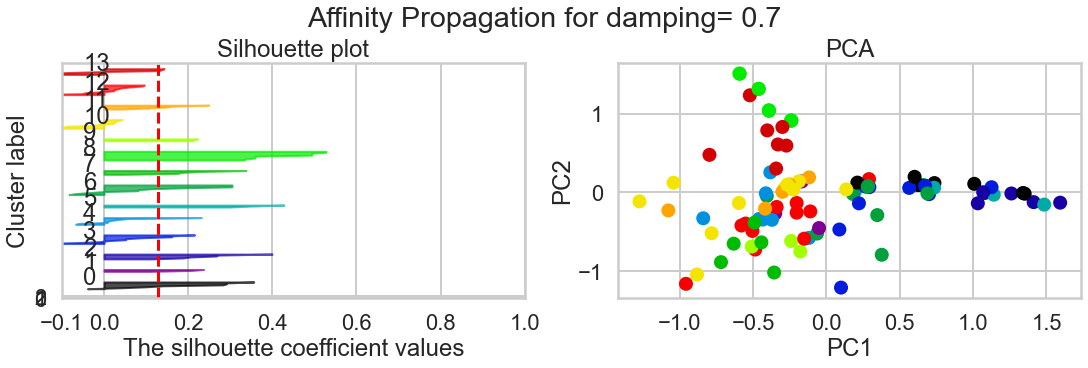

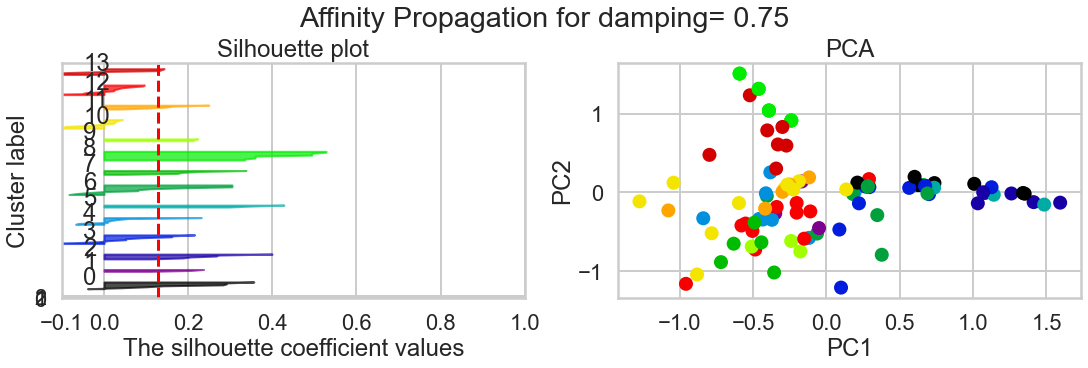

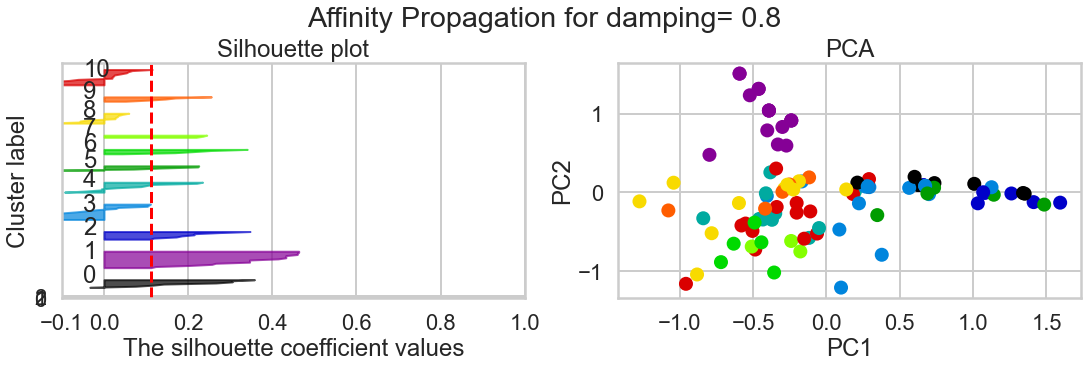

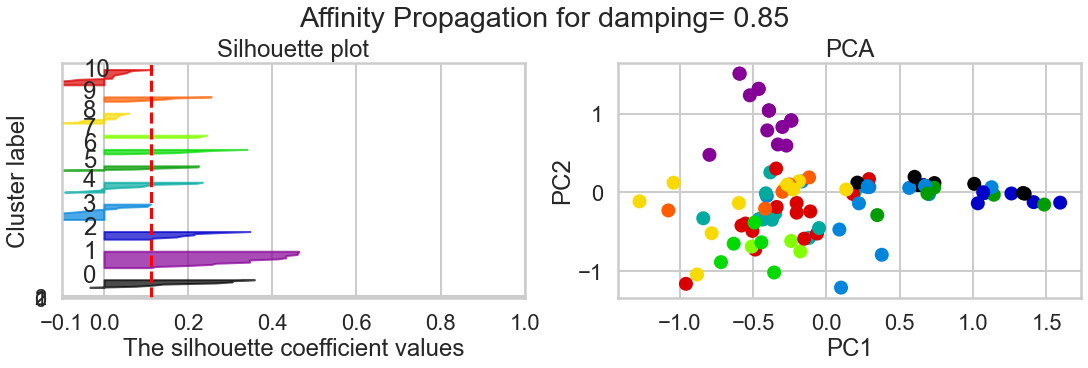

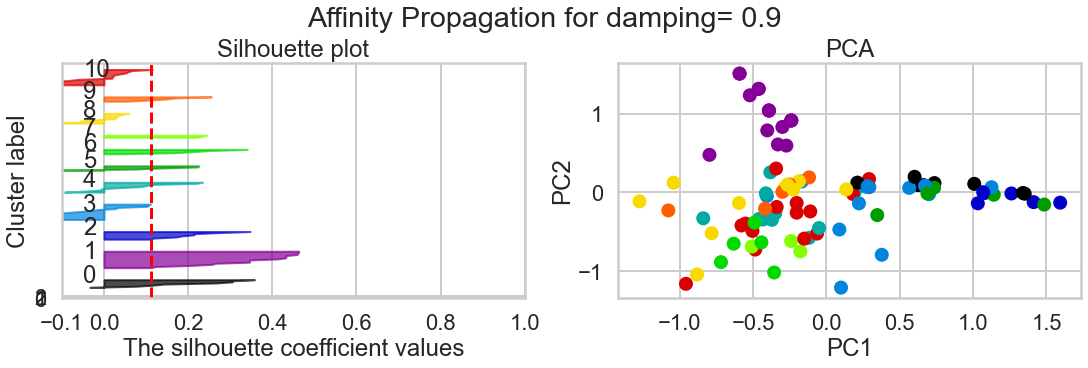

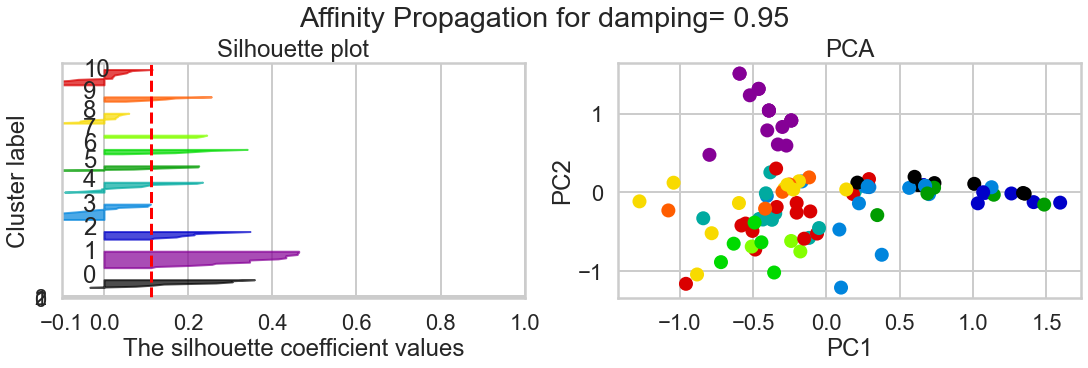

In [24]:
#Affinity Propagation
from sklearn.cluster import AffinityPropagation

clustering = AffinityPropagation(random_state=42).fit(x_cols)

#initialize a df to hold silhouette scores
sil_table = pd.DataFrame(columns=['damping','silhouette_score'])
damping = 0.5

for step in range(10):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1,ax2) = plt.subplots(1, 2, constrained_layout=True)
    fig.set_size_inches(15, 5)
    
   
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 42 for reproducibility.
    clusterer = AffinityPropagation(damping=damping, random_state=42,)
    cluster_labels = clusterer.fit_predict(x_cols)
    
     # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (len(set(cluster_labels))+0.5)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_cols) + (len(set(cluster_labels))+0.5) * 10])
    
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    print(
        "For damping =",
        damping,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    # add silhouette score to a table to plot later
    sil_table.loc[len(sil_table.index)] = [damping,silhouette_avg] 
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(len(set(cluster_labels))):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / len(set(cluster_labels)))
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette plot")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([0,1,2])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    #create df with customer name, cluster id, pc1 and pc2
    pca_df = pd.DataFrame({'customer_name': pivot['customer_name'],
                      'cluster_id': cluster_labels,
                      'x': pc1,
                      'y': pc2})

    #Plot a scatterplot of the `x` vs `y` columns
    #Color-code points differently based on cluster ID
    ax2 = plt.scatter('x', 'y', data=pca_df, c=cm.nipy_spectral(cluster_labels / len(set(cluster_labels))))
    ax2 = plt.xlabel('PC1')
    ax2 = plt.ylabel('PC2')
    ax2 = plt.title('PCA')
    
    fig.suptitle('Affinity Propagation for damping= ' + str(damping))
    damping =round(damping +0.05, 2)
plt.show()

The Affinity Propagation method doesn't improve the average silhouette score when tuned across the damping variable. It tends to create many clusters (between 10 and 13) that do not separate well on the 2-dimensional PCA.

### Spectral Clustering

For n_clusters = 2 The average silhouette_score is : 0.07631909829627558
For n_clusters = 3 The average silhouette_score is : 0.10611539040197304
For n_clusters = 4 The average silhouette_score is : 0.08627893400734331
For n_clusters = 5 The average silhouette_score is : 0.09915711813463922
For n_clusters = 6 The average silhouette_score is : 0.09847779745663406
For n_clusters = 7 The average silhouette_score is : 0.07598262399017487
For n_clusters = 8 The average silhouette_score is : 0.077739004640547
For n_clusters = 9 The average silhouette_score is : 0.08714450020673453
For n_clusters = 10 The average silhouette_score is : 0.085809155141337


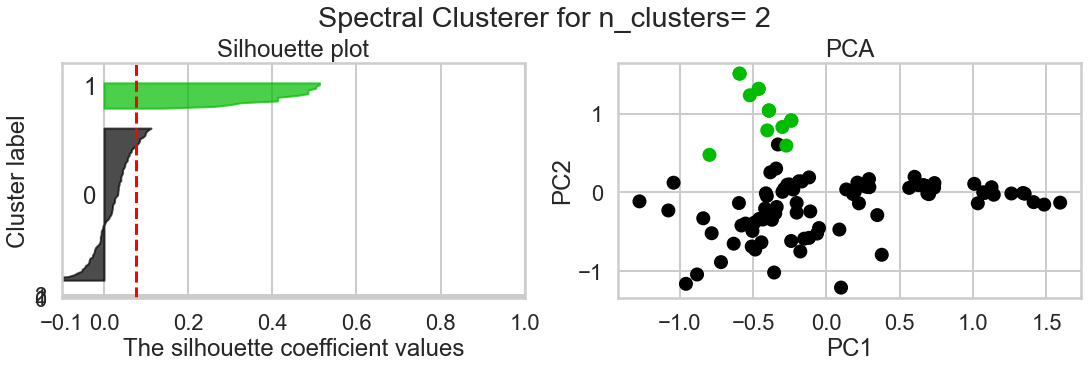

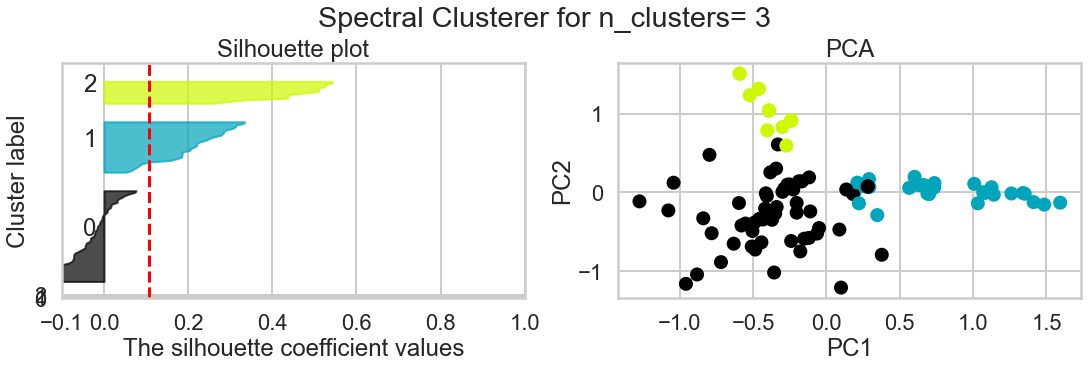

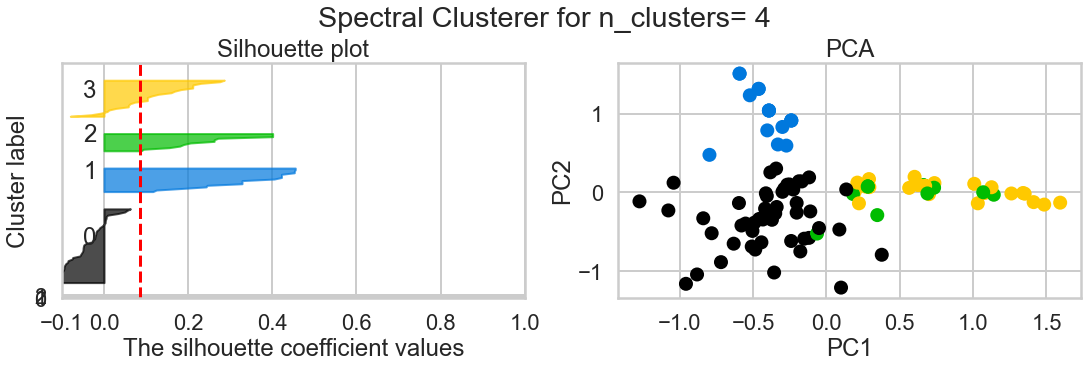

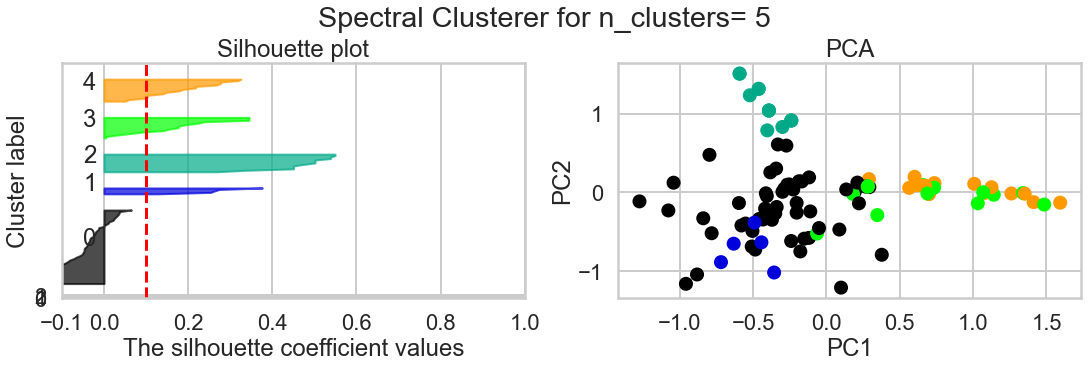

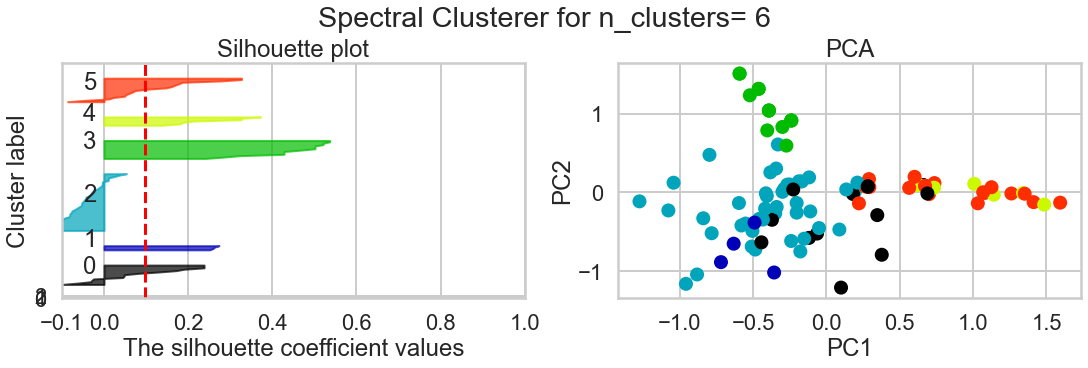

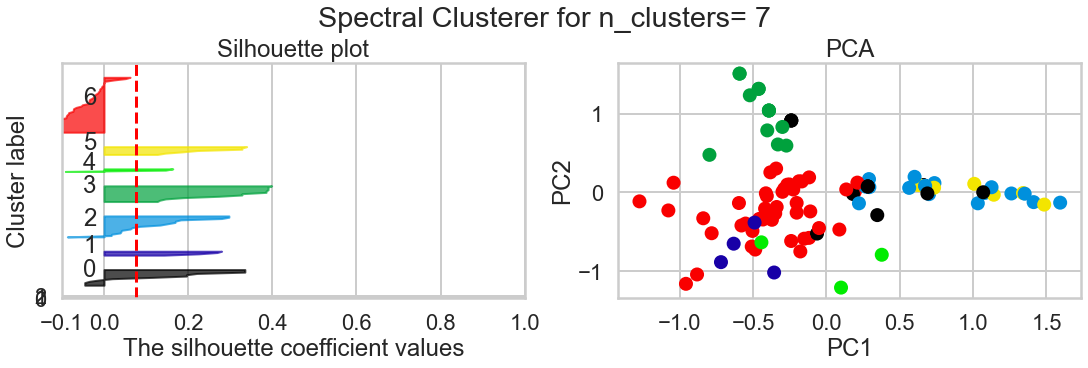

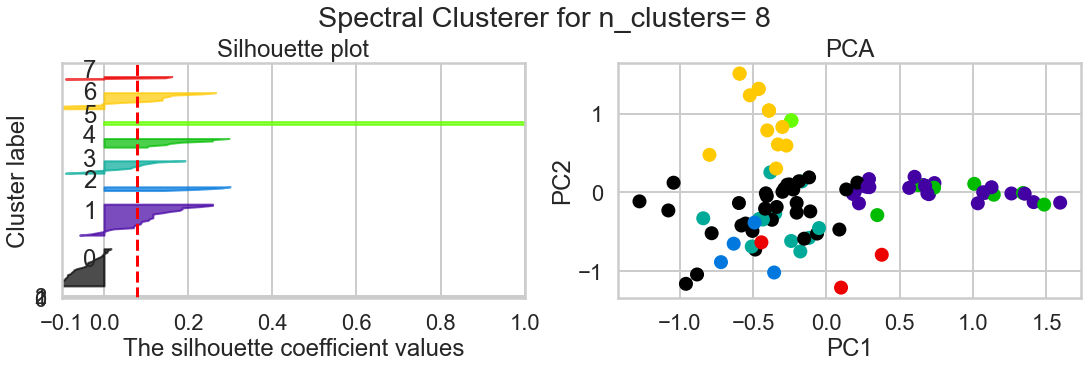

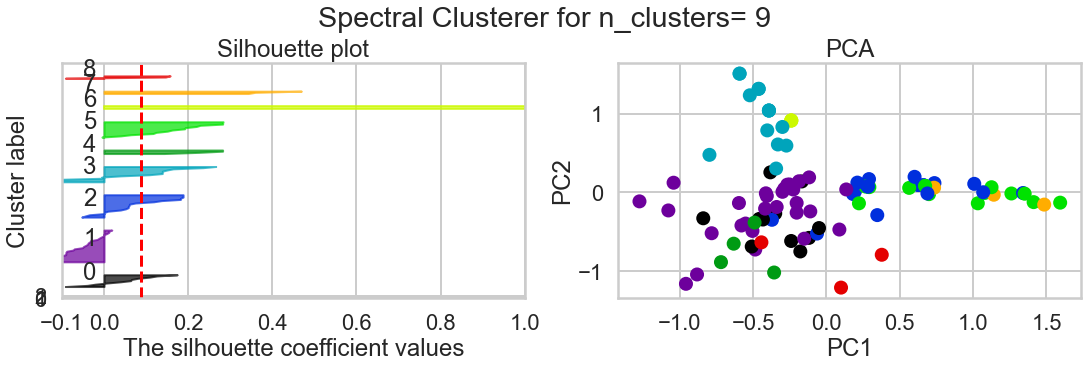

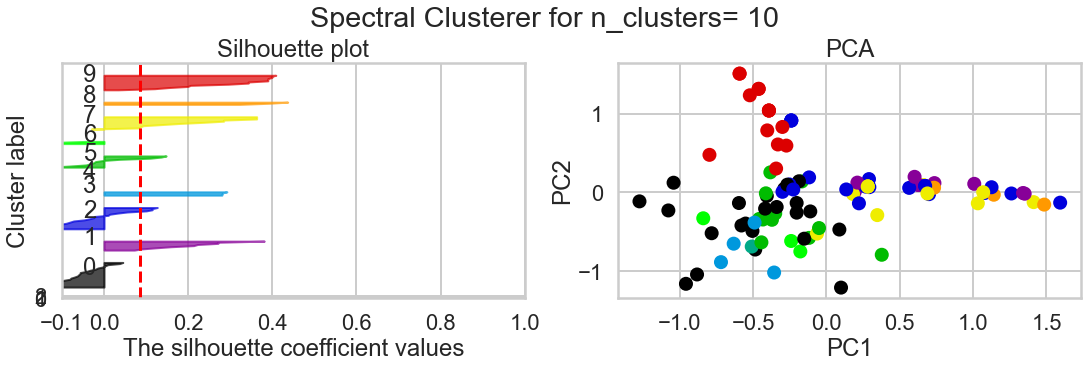

In [25]:
#Spectral clustering
from sklearn.cluster import SpectralClustering

#initialize a df to hold silhouette scores
sil_table = pd.DataFrame(columns=['n_clusters','silhouette_score'])

for n_clusters in range(2,11):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1,ax2) = plt.subplots(1, 2, constrained_layout=True)
    fig.set_size_inches(15, 5)
    
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])
    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 42 for reproducibility.
    clusterer = SpectralClustering(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(x_cols)
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    # add silhouette score to a table to plot later
    sil_table.loc[len(sil_table.index)] = [n_clusters,silhouette_avg] 
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette plot")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([0,1,2])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    #create df with customer name, cluster id, pc1 and pc2
    pca_df = pd.DataFrame({'customer_name': pivot['customer_name'],
                      'cluster_id': cluster_labels,
                      'x': pc1,
                      'y': pc2})

    #Plot a scatterplot of the `x` vs `y` columns
    #Color-code points differently based on cluster ID
    ax2 = plt.scatter('x', 'y', data=pca_df, c=cm.nipy_spectral(cluster_labels / n_clusters))
    ax2 = plt.xlabel('PC1')
    ax2 = plt.ylabel('PC2')
    ax2 = plt.title('PCA')
    
    fig.suptitle('Spectral Clusterer for n_clusters= ' + str(n_clusters))
plt.show()

The Spectral Clustering method shows similar groupings with 3 clusters as our KMeans clusterer from before. However, Spectral Clustering gives a lower silhouette score of 0.10, which makes it unappealing compared the the KMeans silhouette score of 0.12.

### Agglomerative Clustering

labels: [1 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0
 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1
 0 1 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 1 0 1 0 0 1 0 0 0]
For n_clusters = 2 The average silhouette_score is : 0.08258017823184984
For n_clusters = 3 The average silhouette_score is : 0.11625878863607858
For n_clusters = 4 The average silhouette_score is : 0.128937578158815
For n_clusters = 5 The average silhouette_score is : 0.14089739970831974
For n_clusters = 6 The average silhouette_score is : 0.1471521720461323
For n_clusters = 7 The average silhouette_score is : 0.15275152751051155
For n_clusters = 8 The average silhouette_score is : 0.15578053718604024
For n_clusters = 9 The average silhouette_score is : 0.12075124131971901
For n_clusters = 10 The average silhouette_score is : 0.09754750747147792


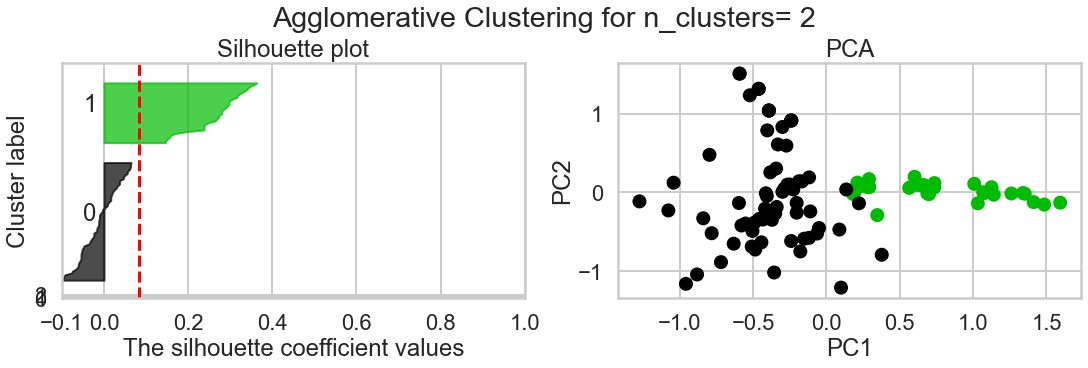

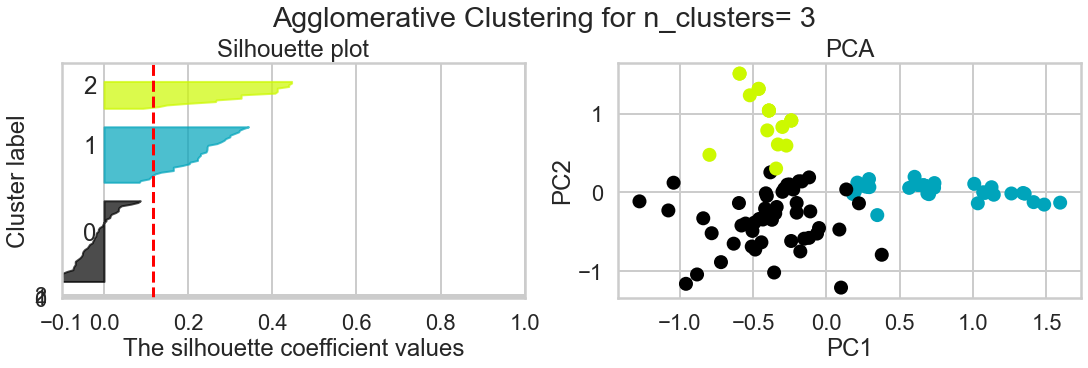

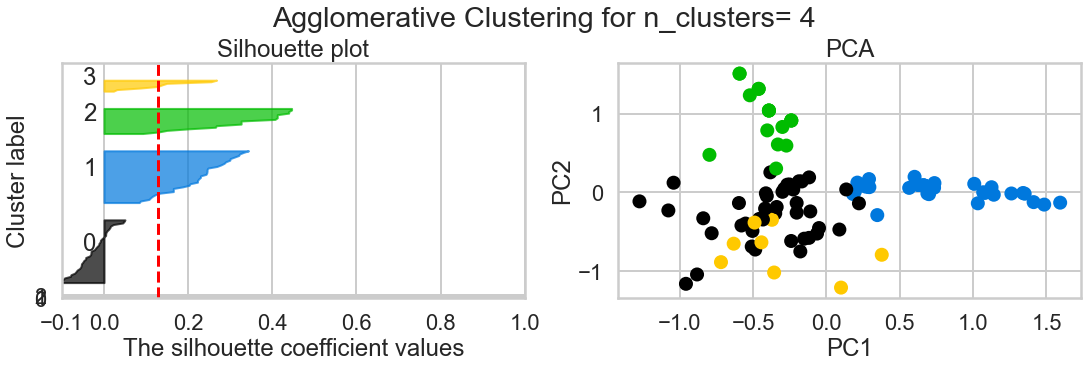

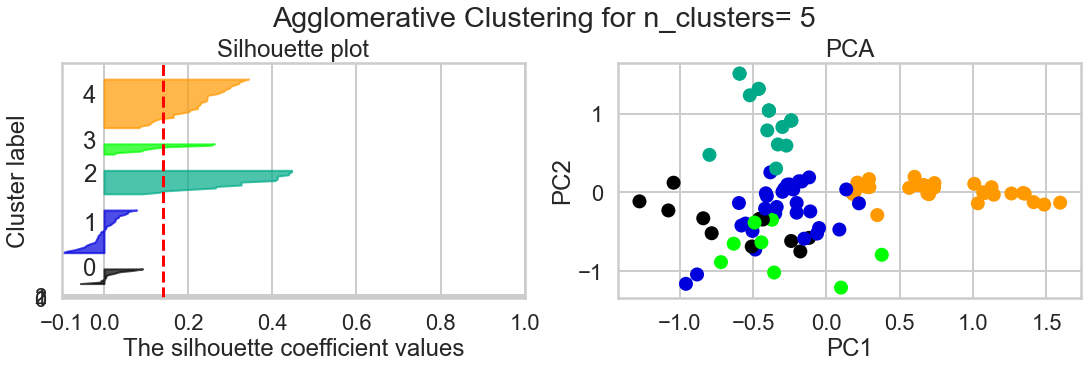

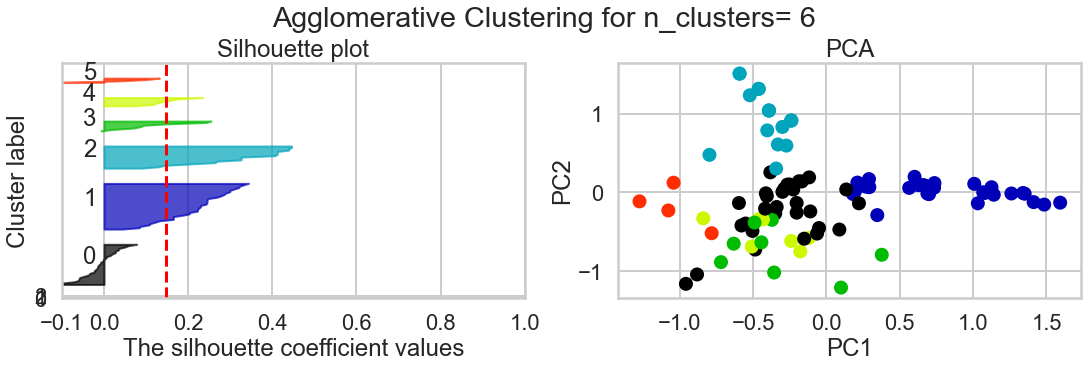

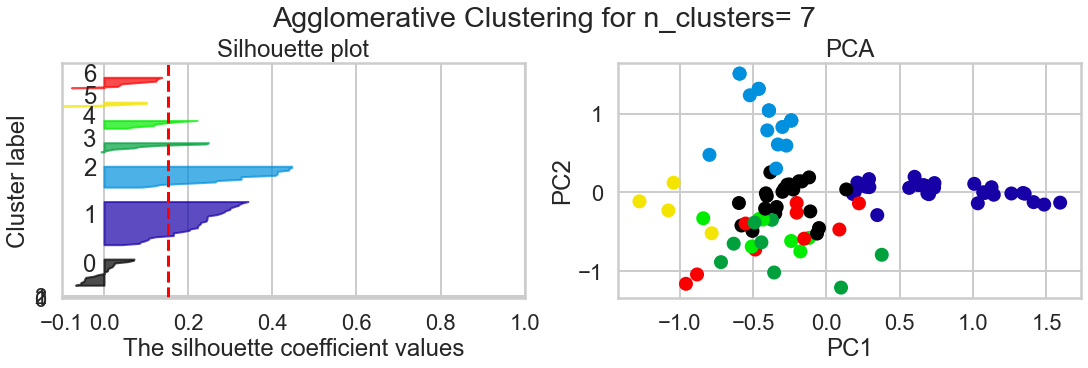

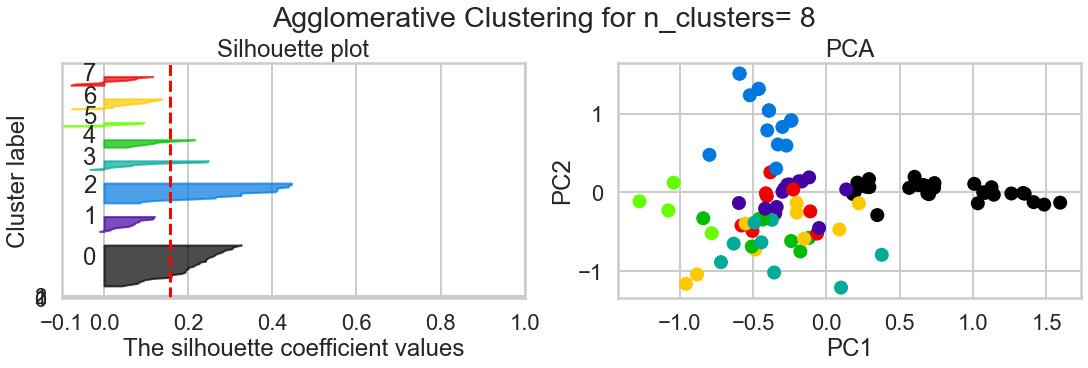

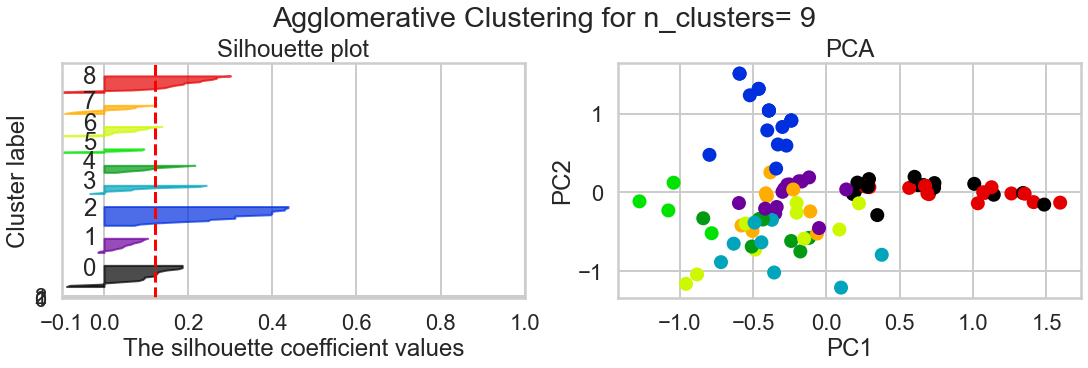

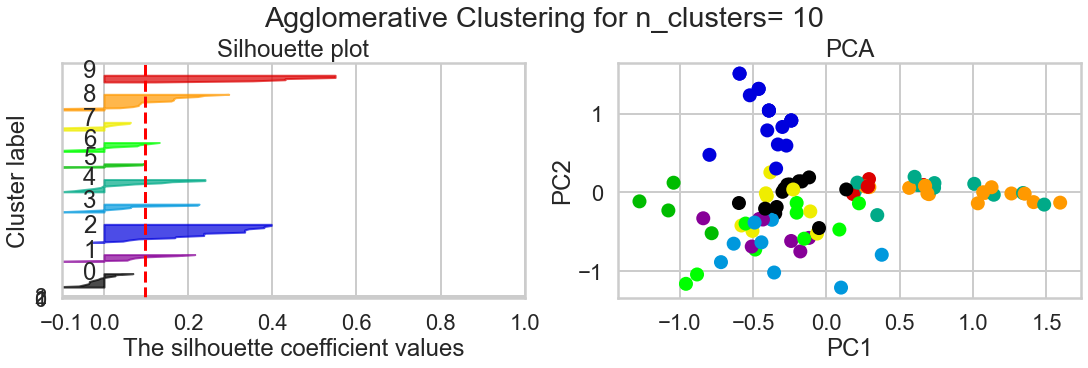

In [26]:
#Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering().fit(x_cols)
print("labels: {}".format(clustering.labels_))

#initialize a df to hold silhouette scores
sil_table = pd.DataFrame(columns=['n_clusters','silhouette_score'])

for n_clusters in range(2,11):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1,ax2) = plt.subplots(1, 2, constrained_layout=True)
    fig.set_size_inches(15, 5)
    
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])
    
    # Initialize the clusterer with n_clusters value.
    clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(x_cols)
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    # add silhouette score to a table to plot later
    sil_table.loc[len(sil_table.index)] = [n_clusters,silhouette_avg] 
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette plot")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([0,1,2])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    #create df with customer name, cluster id, pc1 and pc2
    pca_df = pd.DataFrame({'customer_name': pivot['customer_name'],
                      'cluster_id': cluster_labels,
                      'x': pc1,
                      'y': pc2})

    #Plot a scatterplot of the `x` vs `y` columns
    #Color-code points differently based on cluster ID
    ax2 = plt.scatter('x', 'y', data=pca_df, c=cm.nipy_spectral(cluster_labels / n_clusters))
    ax2 = plt.xlabel('PC1')
    ax2 = plt.ylabel('PC2')
    ax2 = plt.title('PCA')
    
    fig.suptitle('Agglomerative Clustering for n_clusters= ' + str(n_clusters))
plt.show()

Agglomerative Clustering shows a silhouette score of 0.116 for n_clusters = 3, which means it performs about as well as the KMeans clusterer for 3 clusters. Agglomerative Clustering can yeild a higher sil score of 0.156 if the number of clusters is increased to 8, however 8 clusters do not show high differentiation on the 2 dim PCA plot. This method could warrant us going back to investigate if increasing the dimensionality of the PCA may yeild worthwhile insights.

For min_samples = 2 
The average silhouette_score is : -0.04683327471802712 
The estimated number of clusters: 8 
Estimated number of noise points: 81
For min_samples = 3 
The average silhouette_score is : -0.15146236217409403 
The estimated number of clusters: 3 
Estimated number of noise points: 91


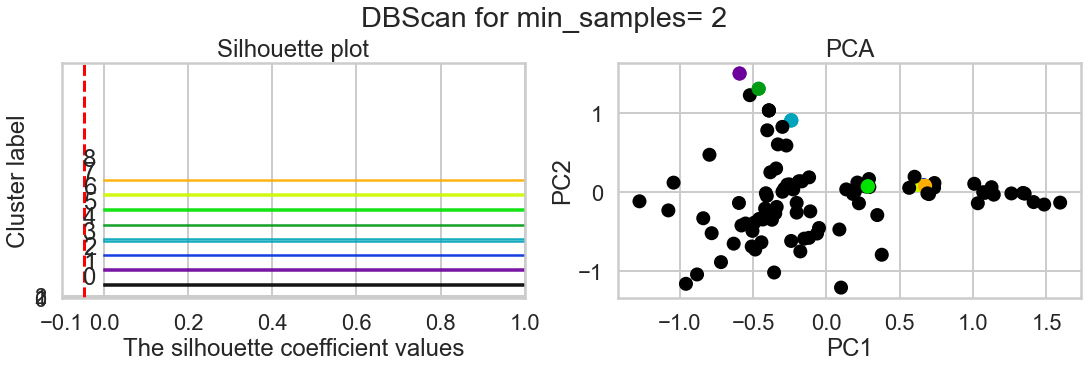

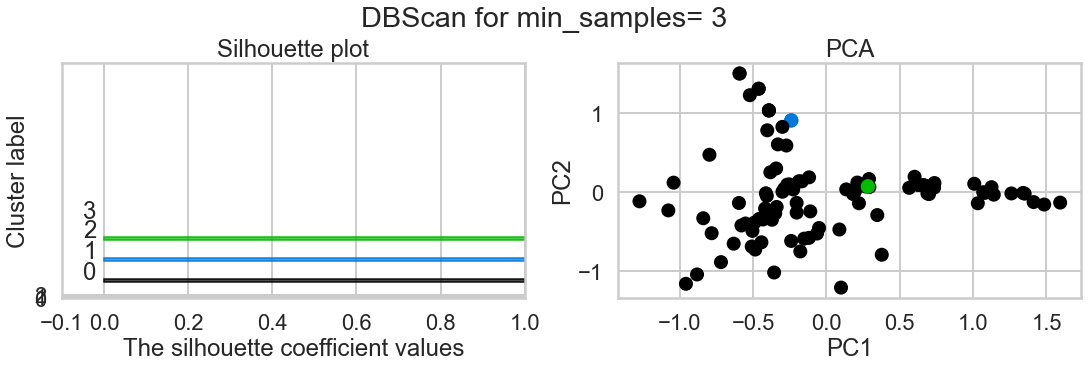

In [27]:
#DBSCAN
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(x_cols)

#initialize a df to hold silhouette scores
sil_table = pd.DataFrame(columns=['min_samples','silhouette_score'])


for min_samples in [2,3]:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1,ax2) = plt.subplots(1, 2, constrained_layout=True)
    fig.set_size_inches(15, 5)
    
   
    # Initialize the clusterer with min_samples value.
    clusterer = DBSCAN(min_samples=min_samples)
    cluster_labels = clusterer.fit_predict(X)
    
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (len(set(cluster_labels))+0.5)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (len(set(cluster_labels))+0.5) * 10])
    
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise_ = list(cluster_labels).count(-1)
    
    print(
        "For min_samples =",
        min_samples,
        "\nThe average silhouette_score is :",
        silhouette_avg,
        "\nThe estimated number of clusters: %d" % n_clusters_,
        "\nEstimated number of noise points: %d" % n_noise_
    )
    # add silhouette score to a table to plot later
    sil_table.loc[len(sil_table.index)] = [min_samples,silhouette_avg] 
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(len(set(cluster_labels))):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / len(set(cluster_labels)))
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette plot")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([0,1,2])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    #create df with customer name, cluster id, pc1 and pc2
    pca_df = pd.DataFrame({'customer_name': pivot['customer_name'],
                      'cluster_id': cluster_labels,
                      'x': pc1,
                      'y': pc2})

    #Plot a scatterplot of the `x` vs `y` columns
    #Color-code points differently based on cluster ID
    ax2 = plt.scatter('x', 'y', data=pca_df, c=cm.nipy_spectral(cluster_labels / len(set(cluster_labels))))
    ax2 = plt.xlabel('PC1')
    ax2 = plt.ylabel('PC2')
    ax2 = plt.title('PCA')
    
    fig.suptitle('DBScan for min_samples= ' + str(min_samples))
    
plt.show()

The DBSCAN is virtually useless for this particular data set--even with tuning the min_samples parameter, it jumps quickly from classifying every data point as it's own group to classifying all data points to one grouping.